In [1]:
import numpy as np

# to set the path for importing HADES modules
import sys
sys.path.append("../source/")

from HadesR.hades_utils import make_statfile, make_datfile, distance_calculation
from HadesR import hades_location
from HadesR import hades_input

from latlon2cart import Coordinates

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# HADES SYNTHETIC EXAMPLE

In this notebook we showcase basic HADES. We create a synthetic cluster of 55 stations and use 2 stations.

In [8]:
# Let's make a synthetic cluster, with synthetic stations

# stations
STA1 = np.array([522,110.3,50])
STA2 = np.array([532,114.45,-21])
station_names = ['STA1' 'STA2']

# cluster
np.random.seed(35)
cluster = np.random.normal(loc=np.array([528, 98.0, 700]), scale=np.array([0.65,0.35,0.22]), size=np.array([55,3]))


# generate homogeneous traveltimes
Vp = 4000
Vs = Vp/1.75

# Distances to each station
distances_sta1 = distance_calculation(cluster, STA1)
distances_sta2 = distance_calculation(cluster, STA2)

# Calculate travel times
tp_sta1, ts_sta1 = distances_sta1 * (1/Vp), distances_sta1 * (1/Vs)
tp_sta2, ts_sta2 = distances_sta2 * (1/Vp), distances_sta2 * (1/Vs)



#### Make a plot

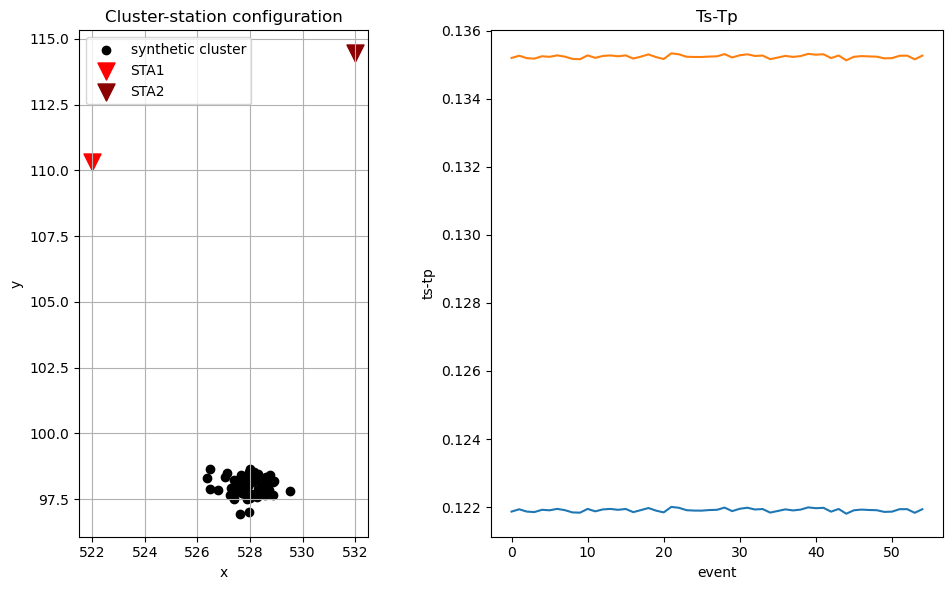

In [26]:
# and let's plot our situation:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.title('Cluster-station configuration')


plt.grid()
plt.gca().set_aspect('equal')
plt.scatter(cluster[:,0], cluster[:,1], c='k', label='synthetic cluster')
plt.scatter(STA1[0], STA1[1], c='r', marker='v', s=150, label='STA1')
plt.scatter(STA2[0], STA2[1], c='darkred', marker='v', s=150, label='STA2')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.title('Ts-Tp')
plt.plot((ts_sta1-tp_sta1))
plt.plot((ts_sta2-tp_sta2))

plt.xlabel('event'), plt.ylabel('ts-tp')

plt.tight_layout()
plt.show()

### Now let's prepare some input files

For this we need to transform our coordinate system to some lat, lon system!

In [27]:
# station file
geo_coords = Coordinates(35, 12)                                      # The real coordinates you want to give them 
sta_coords_1 = geo_coords.cart2geo(E=STA1[0], N=STA1[1], U=0)
np.array(sta_coords_1)[2]=STA1[2]/1000
sta_coords_2 = geo_coords.cart2geo(E=STA2[0], N=STA2[1], U=0)
np.array(sta_coords_2)[2] = STA2[2]/1000

make_statfile(path='./data/inputs/', filename='synthetic_stats', station_names=['STA1', 'STA2'], station_coordinates=np.array([sta_coords_1, sta_coords_2]))

Saved station file ./data/inputs/synthetic_stats  - success!


In [28]:
# First we need some timestamps for the events for some realistic data
timestamp = datetime.fromtimestamp(7e8)    # just a random start date
format = '%Y/%m/%d %H:%M:%S.%f'

picks_p = []
picks_s = []

for i in range(len(cluster)):
    tmp_evtime = timestamp + timedelta(days=i, seconds=i*2.145)                 # add some random time moment so events have different dates and times

    tmp_p = [tmp_evtime + timedelta(seconds=tp_sta1[i]), tmp_evtime + timedelta(seconds=tp_sta1[i])]
    tmp_s = [tmp_evtime + timedelta(seconds=ts_sta1[i]), tmp_evtime + timedelta(seconds=ts_sta1[i])]

    picks_p.append([tmp_p[0].strftime(format), tmp_p[1].strftime(format)])      # %yy/%dd/%mm %H:%M:%S.%f
    picks_s.append([tmp_s[0].strftime(format), tmp_s[1].strftime(format)])      # %yy/%dd/%mm %H:%M:%S.%f


In [30]:
# now we make the input file
# Choose some master events
ref = np.array([0, 17, 18, 24])

evt_coords = geo_coords.cart2geo(E=cluster[:,0], N=cluster[:,1], U=cluster[:,2])

make_datfile(path='./data/inputs/', filename='synthetic_evts', 
            ref_idx=ref, 
            ref_coords=np.array([evt_coords[0][ref], evt_coords[1][ref], cluster[ref, 2]/1000]), 
            origin=np.array([evt_coords[0][ref[0]], evt_coords[1][ref[0]], cluster[ref[0], 2]/1000]), 
            station_names=['STA1', 'STA2'], 
            p_times=picks_p, s_times=picks_s)

Reference event 0 added.
Reference event 17 added.
Reference event 18 added.
Reference event 24 added.
Saved event file ./data/inputs/synthetic_evts - success!


## Start HADES

Now that we've made the *stations* and *events* input files, we can start HADES.

In [32]:
# Let's fetch some files

# input files
general_path = './'
station_file = 'data/inputs/synthetic_stats.txt'
input_file = 'data/inputs/synthetic_evts.dat'

# Declare which two stations you want to use:
stations = ['STA1', 'STA2']     # two selected stations
# in this case we only have two stations in our files, but if 
# you had more in the input files you have to select some

### object creation

In [33]:
# Create a Hades input object hobj with data loaded 

hobj = hades_input(
    data_path = general_path,          # the general path to the data
    event_file = input_file,        # the input event file path
    station_file = station_file,    # the station file path
    sta_select = stations           # your two stations
)

### Start calculation: absolute or relative?

In [34]:
# First we compute the relative distances
hobj.distance_calculation(Vp,Vs,stations)

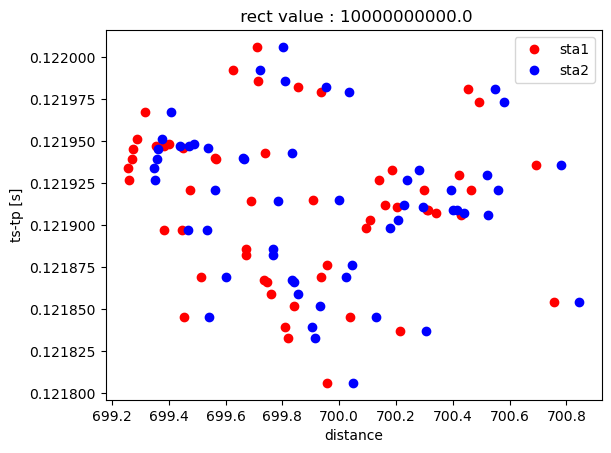

'Location process completed, number of located events: 55 '

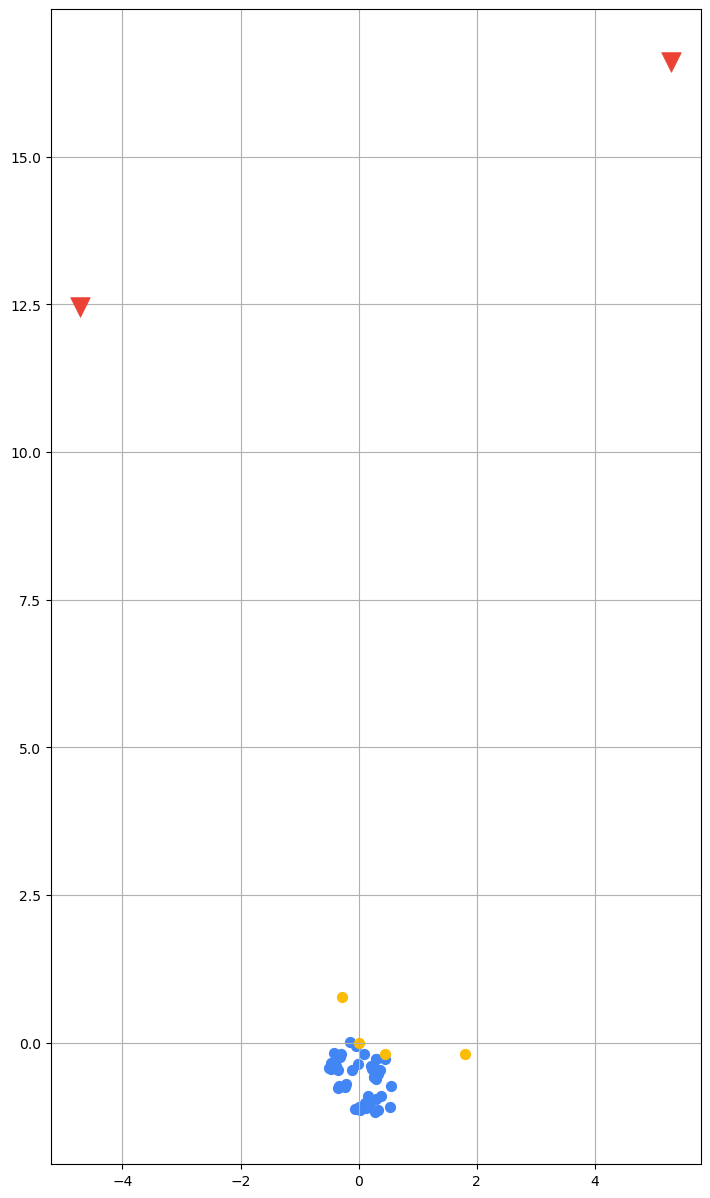

In [35]:
output_path = 'data/outputs/'
output_filename = 'synthetic_output_abs'

# And then we do absolute locations. First make a location instance:
hloc = hades_location(input_obj=hobj, output_path=output_path, output_frame='latlon')
hloc.location(output_filename, mode='abs', plot=True)

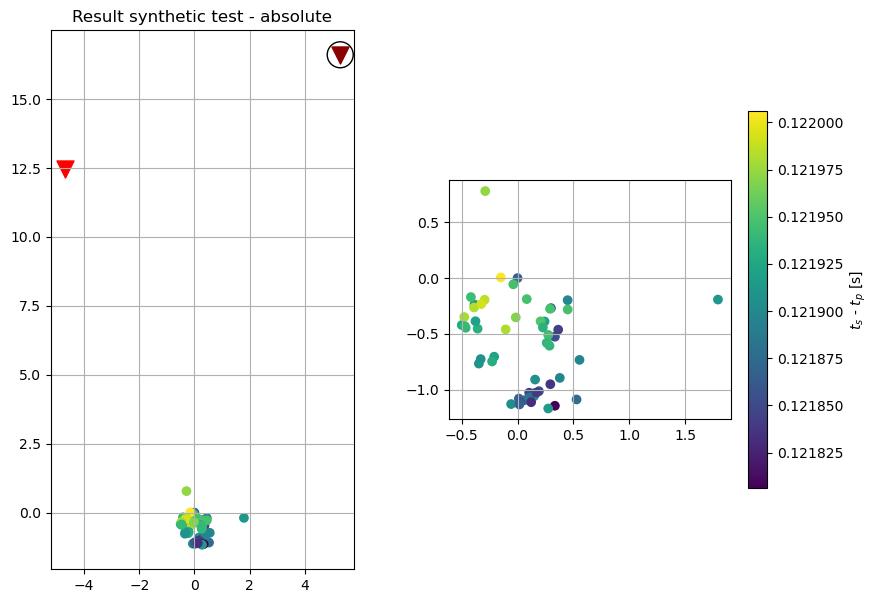

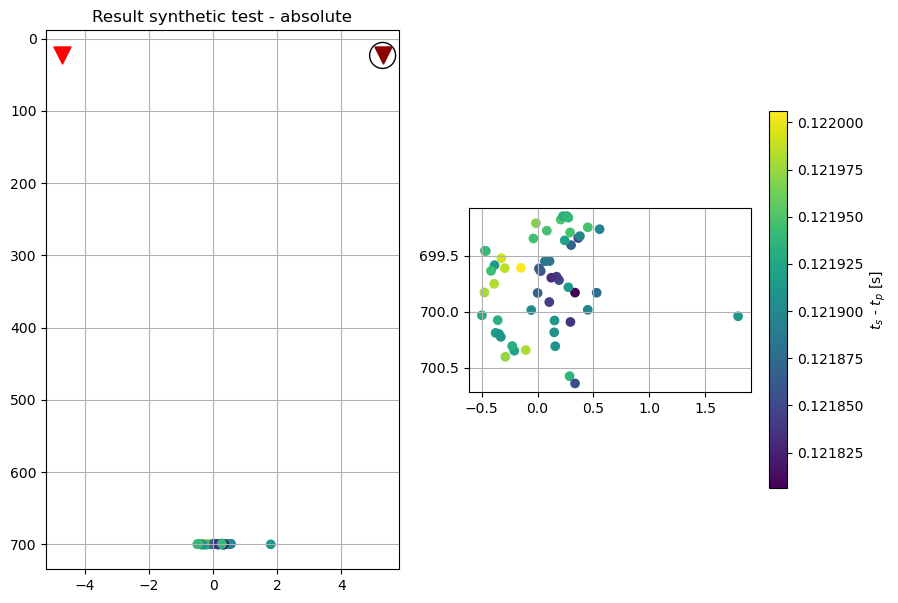

In [46]:
sta_select = 'STA2' # 'STA2'    # selected station for the ts-tp plot

plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.title('Result synthetic test - absolute')
plt.grid()
plt.gca().set_aspect('equal')
plt.scatter(hloc.locations[:,0], hloc.locations[:,1], c=hloc.evtsps[sta_select])
plt.scatter(hobj.stations[sta_select][0], hobj.stations[sta_select][1], facecolor='None', edgecolor='k', marker='o', s=350, label='STA2')
plt.scatter(hobj.stations['STA1'][0], hobj.stations['STA1'][1], c='r', marker='v', s=150, label='STA1')
plt.scatter(hobj.stations['STA2'][0], hobj.stations['STA2'][1], c='darkred', marker='v', s=150, label='STA2')

plt.subplot(1,2,2)
plt.grid()
plt.gca().set_aspect('equal')
im = plt.scatter(hloc.locations[:,0], hloc.locations[:,1], c=hloc.evtsps[sta_select])
plt.colorbar(im, label='$t_s$ - $t_p$ [s]', shrink=.7)


plt.show()




plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.title('Result synthetic test - absolute')
plt.grid()
# plt.gca().set_aspect('equal')
plt.scatter(hloc.locations[:,0], hloc.locations[:,2], c=hloc.evtsps[sta_select])
plt.scatter(hobj.stations[sta_select][0], hobj.stations[sta_select][2]*1000, facecolor='None', edgecolor='k', marker='o', s=350, label='STA2')
plt.scatter(hobj.stations['STA1'][0], hobj.stations['STA1'][2]*1000, c='r', marker='v', s=150, label='STA1')
plt.scatter(hobj.stations['STA2'][0], hobj.stations['STA2'][2]*1000, c='darkred', marker='v', s=150, label='STA2')
plt.gca().invert_yaxis()


plt.subplot(1,2,2)
plt.grid()
plt.gca().set_aspect('equal')
im = plt.scatter(hloc.locations[:,0], hloc.locations[:,2], c=hloc.evtsps[sta_select])
plt.colorbar(im, label='$t_s$ - $t_p$ [s]', shrink=.7)
plt.gca().invert_yaxis()


plt.show()


In [36]:
# Create a new Hades input object hobj with data loaded 

hobj_rel = hades_input(
    data_path = general_path,          # the general path to the data
    event_file = input_file,        # the input event file path
    station_file = station_file,    # the station file path
    sta_select = stations           # your two stations
)

In [37]:
# First we compute the relative distances
hobj_rel.distance_calculation(Vp,Vs,stations)

'Location process completed, number of located events: 55 '

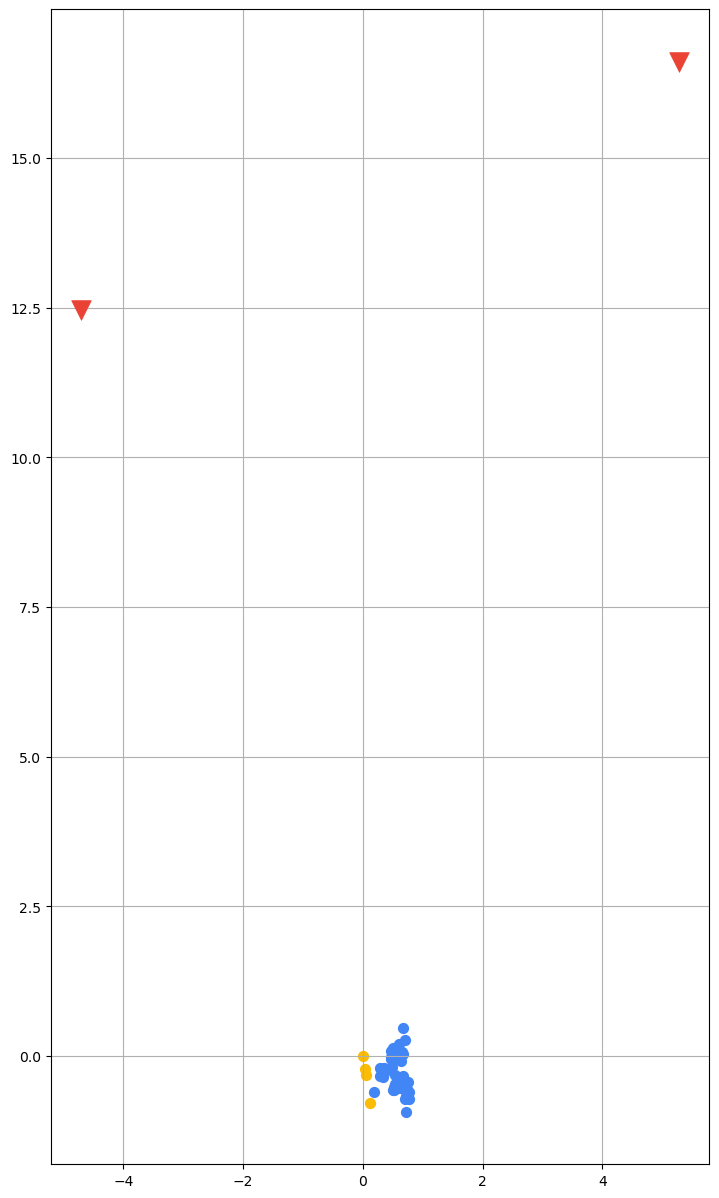

In [38]:
output_path = 'data/outputs/'
output_filename = 'synthetic_output_rel'

# And then we do absolute locations. First make a location instance:
hobj_rel.relative_frame(Vp,Vs,stations,y_ref=-1,z_ref=1,fixed_depth=.001)

hloc_rel = hades_location(input_obj=hobj_rel, output_path=output_path, output_frame='latlon')
hloc_rel.location(output_filename, mode='rel', plot=True)

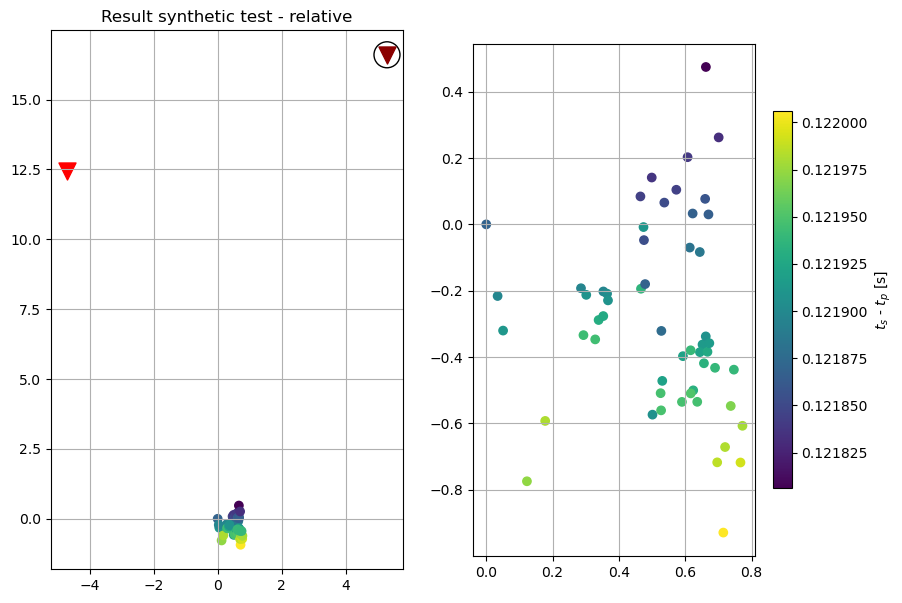

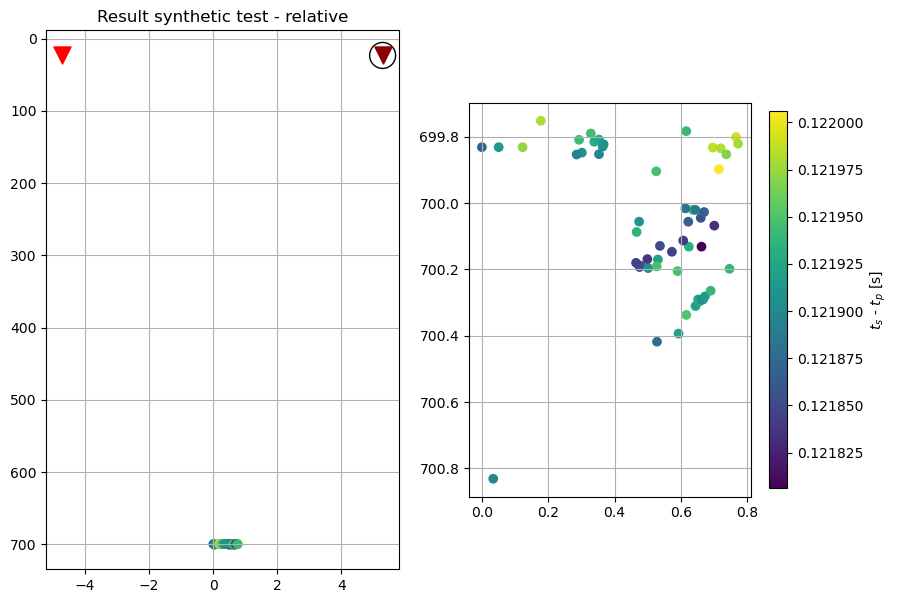

In [47]:
sta_select = 'STA2' # 'STA2'    # selected station for the ts-tp plot

plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.title('Result synthetic test - relative')
plt.grid()
plt.scatter(hloc_rel.locations[:,0], hloc_rel.locations[:,1], c=hloc_rel.evtsps[sta_select])
plt.scatter(hobj_rel.stations[sta_select][0], hobj_rel.stations[sta_select][1], facecolor='None', edgecolor='k', marker='o', s=350, label='STA2')
plt.scatter(hobj_rel.stations['STA1'][0], hobj_rel.stations['STA1'][1], c='r', marker='v', s=150, label='STA1')
plt.scatter(hobj_rel.stations['STA2'][0], hobj_rel.stations['STA2'][1], c='darkred', marker='v', s=150, label='STA2')

plt.subplot(1,2,2)
plt.grid()
plt.gca().set_aspect('equal')
im = plt.scatter(hloc_rel.locations[:,0], hloc_rel.locations[:,1], c=hloc_rel.evtsps[sta_select])
plt.colorbar(im, label='$t_s$ - $t_p$ [s]', shrink=.7)


plt.show()




plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.title('Result synthetic test - relative')
plt.grid()
plt.scatter(hloc_rel.locations[:,0], hloc_rel.locations[:,2], c=hloc_rel.evtsps[sta_select])
plt.scatter(hobj_rel.stations[sta_select][0], hobj_rel.stations[sta_select][2]*1000, facecolor='None', edgecolor='k', marker='o', s=350, label='STA2')
plt.scatter(hobj_rel.stations['STA1'][0], hobj_rel.stations['STA1'][2]*1000, c='r', marker='v', s=150, label='STA1')
plt.scatter(hobj_rel.stations['STA2'][0], hobj_rel.stations['STA2'][2]*1000, c='darkred', marker='v', s=150, label='STA2')
plt.gca().invert_yaxis()


plt.subplot(1,2,2)
plt.grid()
plt.gca().set_aspect('equal')
im = plt.scatter(hloc_rel.locations[:,0], hloc_rel.locations[:,2], c=hloc_rel.evtsps[sta_select])
plt.colorbar(im, label='$t_s$ - $t_p$ [s]', shrink=.7)
plt.gca().invert_yaxis()


plt.show()
